# Revised Magnitude tests
What exactly does magnitude correlate in word embeddings from Large Language Models? Can we find markers of complexity in differences between clearly defined groups of English language words?

I will compare dialects (British-English, American-English), plurals (wife, wives), and Oxford Corpus frequencies as a part of attempting to investigate these issues.

In [1]:
import os
import torch
import openai
import numpy as np

import sentencepiece    # necessary for proper t5 init.
from transformers import T5Tokenizer, T5EncoderModel, GPT2Tokenizer, OPTModel

from sklearn.metrics.pairwise import cosine_similarity

# api key set in conda env.
openai.api_key = os.getenv('OPENAI_API_KEY')

## Load Models

### Vocab

In [2]:
vocab = []
with open('./vocab/expanded_vocab.txt', 'r') as f:
    for line in f:
        vocab.append(line.strip())

len(vocab)

5124

In [3]:
top_50 = []
with open('./vocab/top_50.txt', 'r') as f:
    for line in f:
        top_50.append(line.strip())

bottom_50 = []
with open('./vocab/bottom_50.txt', 'r') as f:
    for line in f:
        bottom_50.append(line.strip())

### OPT-1.3b

In [4]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('facebook/opt-1.3b', cache_dir='/scratch/mbarlow6/.cache')
model_opt_raw = OPTModel.from_pretrained('facebook/opt-1.3b', cache_dir='/scratch/mbarlow6/.cache')

Some weights of the model checkpoint at facebook/opt-1.3b were not used when initializing OPTModel: ['model.decoder.final_layer_norm.weight', 'model.decoder.final_layer_norm.bias', 'lm_head.weight']
- This IS expected if you are initializing OPTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
opt_embeds = []
with open(u'./opt/1_3B.txt', 'r') as f:
    for line in f:
        opt_embeds.append([float(x) for x in line.strip().split()])
model_opt = dict(zip(vocab, opt_embeds))

In [6]:
def opt_embed(text, tokenizer=gpt2_tokenizer, model=model_opt_raw, debug=False):
    inputs = tokenizer(text, return_tensors='pt')
    if debug:
        print('Tokens Requested:')
        print(tokenizer.batch_decode(inputs.input_ids[0]))
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.squeeze(outputs.last_hidden_state, dim=0)
    return np.array(torch.mean(embeddings[1:], dim=0))

### T5

In [7]:
t5_tokenizer = T5Tokenizer.from_pretrained('t5-large', cache_dir='/scratch/mbarlow6/.cache')
model_t5_raw = T5EncoderModel.from_pretrained('t5-large', cache_dir='/scratch/mbarlow6/.cache')

/home/mbarlow6/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Some weights of the model checkpoint at t5-large were not used when initializing T5EncoderModel: ['decoder.block.7.layer.1.layer_norm.weight', 'decoder.block.9.layer.1.EncDecAttention.o.weight', 'decoder.block.1.layer.1.layer_norm.weight

In [8]:
t5_embeds = []
with open('./t5/t5large.txt', 'r') as f:
    for line in f:
        t5_embeds.append([float(x) for x in line.strip().split()])
model_t5 = dict(zip(vocab, t5_embeds))

In [9]:
def t5_embed(text, tokenizer=t5_tokenizer, model=model_t5_raw, debug=False):
    inputs = tokenizer(text, return_tensors='pt')
    if debug:
        print('Tokens Requested:')
        print(tokenizer.batch_decode(inputs.input_ids[0]))
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.squeeze(outputs.last_hidden_state, dim=0)
    return np.array(torch.mean(embeddings, dim=0))

## Helper Functions

In [10]:
def positive(words, model='opt'):
    """
    Args:
        words: iterable
        model: 'opt' or 't5'
    Returns:
        Positive (summed vectors) of word embeddings of a given list of words from the specified model. Defaults to OPT-1.3b.
    """
    if isinstance(words, str):
        print(f"You requested the positive of the string \"{words}\". Did you mean [\"{words}\"]?")

    out = 0
    for token in words:
        word = str(token)
        if model.lower() == 'opt':
            if word in model_opt:
                ex = model_opt[word]
            else:
                ex = opt_embed(word)
                model_opt[word] = ex
        elif model.lower() == 't5':
            if word in model_t5:
                ex = model_t5[word]
            else:
                ex = t5_embed(word)
                model_t5[word] = ex
        else:
            raise ValueError('Please provide either opt or t5 as a model choice.')

        # construct positive
        if isinstance(out, int):
            out = np.array(ex).reshape(1, -1)
        else:
            out += np.array(ex).reshape(1, -1)
            
    return out if not isinstance(out, int) else np.array([])

In [11]:
def sum_complexity(word, vec=False, model='opt'):
    """
    Args:
        word: iterable, string, or vector   -> embedding to be summed.
        vec: bool                           -> True if word is already vector.
        model: str                          -> 'opt' or 't5'
    Returns:
        Float score of the sum of the absolute value of each datapoint in the embedding.
    """
    phrase = word
    if not vec:
        if isinstance(word, str):
            phrase = positive([word], model=model)
        else:
            phrase = positive(word, model=model)
    
    modified = [abs(float(x)) for x in phrase[0]]
    return sum(modified)
    

In [12]:
def simple_sum(word, vec=False, model='opt'):
    """
    Args:
        word: iterable, string, or vector   -> embedding to be summed.
        vec: bool                           -> True if word is already vector.
        model: str                          -> 'opt' or 't5'
    Returns:
        Float score of the simple sum of each datapoint in the embedding.
    """
    phrase = word
    if not vec:
        if isinstance(word, str):
            phrase = positive([word], model=model)
        else:
            phrase = positive(word, model=model)
    
    modified = [float(x) for x in phrase[0]]
    return sum(modified)

In [13]:
def similar_dims(w1, w2, n=10):
    # performs dimension-wise comparison of two vectors of EQUAL size
    # returns the top and bottom n scores.
    sims = []
    for i in range(w1.shape[1]):
        x = w1[0][i]
        y = w2[0][i]
        sims.append((i, (x, y), abs(x-y)))
    sims.sort(key=lambda x: x[2])
    return sims[:n], sims[len(sims)-n:]

In [33]:
def compare_mag(words):
    """
    Wrapper for direct comparison using our magnitude tests
    """
    if isinstance(words, str):
        words = [words] 
    for word in words:
        print(word)
        print(f"\t\tOPT\t\t\tT5")
        print(f"Simple Sum:\t{simple_sum(word)}\t{simple_sum(word, model='t5')}")
        print(f"Absolute Sum:\t{sum_complexity(word)}\t{sum_complexity(word, model='t5')}")
        print('--------------------------------------------------------------\n')
        

## Run Tests

### American -> British English

In [34]:
compare_mag(['color', 'colour'])

color
		OPT			T5
Simple Sum:	-24.199456945061684	-4.4587583602406085
Absolute Sum:	3338.171229749918	112.67953831842169
--------------------------------------------------------------

colour
		OPT			T5
Simple Sum:	-22.662603956949933	-0.01963315483000075
Absolute Sum:	3335.5094612935595	102.75824530782984
--------------------------------------------------------------



In [35]:
compare_mag(['flavor', 'flavour'])

flavor
		OPT			T5
Simple Sum:	-33.566729525104165	-4.6213948333170265
Absolute Sum:	2553.7569937165827	108.81001204042695
--------------------------------------------------------------

flavour
		OPT			T5
Simple Sum:	-31.49281551646394	0.8406818178199947
Absolute Sum:	2586.2954213954436	93.8045069266
--------------------------------------------------------------



In [36]:
compare_mag(['apologize', 'apologise'])

apologize
		OPT			T5
Simple Sum:	-40.51664127009994	1.131177949715998
Absolute Sum:	2996.214361116699	120.69495491850398
--------------------------------------------------------------

apologise
		OPT			T5
Simple Sum:	-36.695555716753006	-2.0030089664433035
Absolute Sum:	2953.673937305808	62.17443947496213
--------------------------------------------------------------



In [37]:
compare_mag(['organize', 'organise'])

organize
		OPT			T5
Simple Sum:	-48.99945621659992	4.158821312727008
Absolute Sum:	2884.713562120402	117.27759976698687
--------------------------------------------------------------

organise
		OPT			T5
Simple Sum:	-43.70867237821221	2.870686980546452
Absolute Sum:	2863.3498784564435	93.91056684602518
--------------------------------------------------------------



In [38]:
compare_mag(['analyze', 'analyse'])

analyze
		OPT			T5
Simple Sum:	-37.04013854265213	3.602266021305695
Absolute Sum:	2606.2433263212442	119.0364482162986
--------------------------------------------------------------

analyse
		OPT			T5
Simple Sum:	-30.81358285315035	7.398864579660009
Absolute Sum:	2651.8206000805553	113.73996778445986
--------------------------------------------------------------



In [39]:
compare_mag(['traveled', 'travelled'])

traveled
		OPT			T5
Simple Sum:	-23.362738974392414	-0.5703872325830162
Absolute Sum:	3241.784173555672	119.44546336261556
--------------------------------------------------------------

travelled
		OPT			T5
Simple Sum:	-46.70141828793567	2.2768816815223545
Absolute Sum:	2560.8489447111497	96.65132482850458
--------------------------------------------------------------



In [40]:
compare_mag(['maneuver', 'manoeuvre'])

maneuver
		OPT			T5
Simple Sum:	-54.64741054340266	6.0926067642867565
Absolute Sum:	2482.6454264416825	117.19327442254871
--------------------------------------------------------------

manoeuvre
		OPT			T5
Simple Sum:	-53.18171181541402	2.052766346576391
Absolute Sum:	2764.0729985776125	111.96922191584599
--------------------------------------------------------------



In [41]:
compare_mag(['pediatric', 'paediatric'])

pediatric
		OPT			T5
Simple Sum:	-42.69999048486352	-5.073570327484049
Absolute Sum:	2622.081271354109	132.95897158107255
--------------------------------------------------------------

paediatric
		OPT			T5
Simple Sum:	-47.01118626992684	5.113009257009253
Absolute Sum:	2472.705970560317	87.10109771904536
--------------------------------------------------------------



In [42]:
compare_mag(['license', 'licence'])

license
		OPT			T5
Simple Sum:	1.0644383036001321	1.718059176934
Absolute Sum:	2643.3840186575994	111.15593933449402
--------------------------------------------------------------

licence
		OPT			T5
Simple Sum:	-31.660695239299926	1.4107092056999957
Absolute Sum:	2489.0596044227	74.78809330620007
--------------------------------------------------------------



In [43]:
compare_mag(['offence', 'offense'])

offence
		OPT			T5
Simple Sum:	-44.55477309316994	-2.84851692696
Absolute Sum:	2785.8218766989685	119.99849496604003
--------------------------------------------------------------

offense
		OPT			T5
Simple Sum:	-46.572157309499985	2.984876640603298
Absolute Sum:	2836.9261814895026	116.24461967640323
--------------------------------------------------------------



In [44]:
compare_mag(['analog', 'analogue'])

analog
		OPT			T5
Simple Sum:	-76.26342221349478	5.17538236733526
Absolute Sum:	3077.7593590542674	118.81355411047116
--------------------------------------------------------------

analogue
		OPT			T5
Simple Sum:	-77.15367209166288	7.2690307177836075
Absolute Sum:	3010.94985435158	93.6674624356674
--------------------------------------------------------------



In [45]:
compare_mag(['que', 'queue'])

que
		OPT			T5
Simple Sum:	-63.15537253394723	5.086666775518097
Absolute Sum:	3409.3212755210698	102.73635323217604
--------------------------------------------------------------

queue
		OPT			T5
Simple Sum:	-39.35446859151125	6.712363118305802
Absolute Sum:	3227.2890724763274	101.52983825467527
--------------------------------------------------------------



### Simple plurals

In [46]:
compare_mag(['wife', 'wives'])

wife
		OPT			T5
Simple Sum:	5.2352011217000145	2.3213250735199944
Absolute Sum:	3150.2644422225003	120.24246082537995
--------------------------------------------------------------

wives
		OPT			T5
Simple Sum:	-21.340956543600008	3.684012345699996
Absolute Sum:	3327.6775250679984	116.32066381949998
--------------------------------------------------------------



In [47]:
compare_mag(['dog', 'dogs'])

dog
		OPT			T5
Simple Sum:	-47.83055397659989	1.80793094441
Absolute Sum:	3529.7578563156044	108.30607459486987
--------------------------------------------------------------

dogs
		OPT			T5
Simple Sum:	-36.11718611419201	4.376995865255594
Absolute Sum:	3880.2020541727543	109.27549522183836
--------------------------------------------------------------



In [48]:
compare_mag(['tooth', 'teeth'])

tooth
		OPT			T5
Simple Sum:	-44.58159053990502	3.250715236772008
Absolute Sum:	2686.259456848905	108.15213732227984
--------------------------------------------------------------

teeth
		OPT			T5
Simple Sum:	-36.82766641676426	-3.1485697282478213
Absolute Sum:	2646.0478629544377	107.51873804815114
--------------------------------------------------------------



In [49]:
compare_mag(['man', 'men'])

man
		OPT			T5
Simple Sum:	-64.18488905360003	7.315290854330005
Absolute Sum:	3869.585996808201	111.46183970193012
--------------------------------------------------------------

men
		OPT			T5
Simple Sum:	-45.58764132857323	3.4247365419287235
Absolute Sum:	3482.785582691431	114.117473177379
--------------------------------------------------------------



In [50]:
compare_mag(['potato', 'potatoes'])

potato
		OPT			T5
Simple Sum:	-53.60102776467992	3.1250831901499976
Absolute Sum:	2793.429770354919	81.86353979565003
--------------------------------------------------------------

potatoes
		OPT			T5
Simple Sum:	-49.429247196763754	3.0209543890086934
Absolute Sum:	2885.635482121259	81.42252600681968
--------------------------------------------------------------



In [51]:
compare_mag(['mouse', 'mice'])

mouse
		OPT			T5
Simple Sum:	-36.43019589219998	1.0572799397300021
Absolute Sum:	3281.747351005595	111.88106556272993
--------------------------------------------------------------

mice
		OPT			T5
Simple Sum:	-40.35464038141072	-3.4264453761279583
Absolute Sum:	2615.5033212844282	123.51627621427178
--------------------------------------------------------------



In [52]:
compare_mag(['child', 'children'])

child
		OPT			T5
Simple Sum:	-25.49193802570003	3.2905308800700026
Absolute Sum:	3561.558583227292	115.68451264926999
--------------------------------------------------------------

children
		OPT			T5
Simple Sum:	6.657071084600037	0.6771771735599993
Absolute Sum:	3853.2917559274088	82.13431473671992
--------------------------------------------------------------



In [53]:
compare_mag(['person', 'persons', 'people'])

person
		OPT			T5
Simple Sum:	-34.207746076799936	0.9811889575899998
Absolute Sum:	3290.3820164716017	107.8111367315703
--------------------------------------------------------------

persons
		OPT			T5
Simple Sum:	-23.607827052474022	1.4094845068175346
Absolute Sum:	2840.252486422658	108.84014614089392
--------------------------------------------------------------

people
		OPT			T5
Simple Sum:	-12.613742782499838	3.2900320228299944
Absolute Sum:	3982.6095925145	104.95029256862989
--------------------------------------------------------------



In [54]:
compare_mag(['radius', 'radii'])

radius
		OPT			T5
Simple Sum:	-8.278491022996604	5.3448941393289715
Absolute Sum:	2811.8561052503064	116.98915689601563
--------------------------------------------------------------

radii
		OPT			T5
Simple Sum:	-61.58824963495135	-0.23381295055150986
Absolute Sum:	2652.7567174322903	72.15897057577968
--------------------------------------------------------------



In [55]:
compare_mag(['nucleus', 'nuclei'])

nucleus
		OPT			T5
Simple Sum:	-20.07779145576933	4.065568919526413
Absolute Sum:	2047.1543793298624	91.8775368758943
--------------------------------------------------------------

nuclei
		OPT			T5
Simple Sum:	-29.628134763799608	3.789643097901717
Absolute Sum:	2384.7322511188686	91.0936036661733
--------------------------------------------------------------



In [56]:
compare_mag(['alumna', 'alumnae', 'alumnus', 'alumni'])

alumna
		OPT			T5
Simple Sum:	-27.125099192431662	3.5923549380822806
Absolute Sum:	2359.3590503762825	82.85628350918705
--------------------------------------------------------------

alumnae
		OPT			T5
Simple Sum:	-21.40043980255723	3.5577552693284815
Absolute Sum:	2475.8629604168236	60.907607917673886
--------------------------------------------------------------

alumnus
		OPT			T5
Simple Sum:	-26.3416347593884	2.398935267847264
Absolute Sum:	2610.168458725966	68.47042606078321
--------------------------------------------------------------

alumni
		OPT			T5
Simple Sum:	-28.768758110702038	3.400506461970508
Absolute Sum:	2655.9378338456154	117.26870074216276
--------------------------------------------------------------



In [57]:
compare_mag(['crisis', 'crises'])

crisis
		OPT			T5
Simple Sum:	-25.404675625800024	6.867345018429998
Absolute Sum:	2579.993355488804	108.64256396909002
--------------------------------------------------------------

crises
		OPT			T5
Simple Sum:	-28.352550711482763	4.8642658572716755
Absolute Sum:	2781.3179795481265	106.21351260926895
--------------------------------------------------------------



In [58]:
compare_mag(['thesis', 'theses'])

thesis
		OPT			T5
Simple Sum:	-38.45091626011496	3.8622572925699994
Absolute Sum:	2783.1333081299103	110.68575970296997
--------------------------------------------------------------

theses
		OPT			T5
Simple Sum:	-59.284751288592815	3.3588664353264903
Absolute Sum:	3059.0464252606034	112.33099600310015
--------------------------------------------------------------



In [59]:
compare_mag(['phenomenon', 'phenomena'])

phenomenon
		OPT			T5
Simple Sum:	-30.24391970434226	2.9884221760439686
Absolute Sum:	2341.13470050483	111.42351524234982
--------------------------------------------------------------

phenomena
		OPT			T5
Simple Sum:	-23.14230348158162	3.5862355935387313
Absolute Sum:	2331.2056956771994	112.380532420706
--------------------------------------------------------------



In [60]:
compare_mag(['datum', 'data'])

datum
		OPT			T5
Simple Sum:	-71.05764174833894	6.543937445821939
Absolute Sum:	2672.8676150925457	80.37114760113764
--------------------------------------------------------------

data
		OPT			T5
Simple Sum:	-11.910216334939944	4.078968599414705
Absolute Sum:	3412.7526203524567	114.8487104715854
--------------------------------------------------------------



In [61]:
compare_mag(['bacterium', 'bacteria'])

bacterium
		OPT			T5
Simple Sum:	-25.346489826450124	-4.5271947521250695
Absolute Sum:	2271.9474991869647	86.44896323629655
--------------------------------------------------------------

bacteria
		OPT			T5
Simple Sum:	-9.363450242769947	-0.6039788491399988
Absolute Sum:	2768.6694723976275	120.52002842686001
--------------------------------------------------------------



In [62]:
compare_mag(['index', 'indicies'])

index
		OPT			T5
Simple Sum:	-13.098750994100023	3.70770873129
Absolute Sum:	2599.4648161596997	116.6417214493899
--------------------------------------------------------------

indicies
		OPT			T5
Simple Sum:	-44.70684956526384	-1.2387677724618698
Absolute Sum:	2340.2651076880284	88.84923340844398
--------------------------------------------------------------



In [63]:
compare_mag(['appendix', 'appendices', 'appendixes'])

appendix
		OPT			T5
Simple Sum:	-32.03058958798647	2.0561420577578247
Absolute Sum:	2606.5007516369224	89.41537901898846
--------------------------------------------------------------

appendices
		OPT			T5
Simple Sum:	-27.090383108705282	1.7053398891512188
Absolute Sum:	2682.1718791611493	78.23491011918668
--------------------------------------------------------------

appendixes
		OPT			T5
Simple Sum:	-27.89384383126162	1.5155429612914304
Absolute Sum:	2674.339427118888	67.41511475971674
--------------------------------------------------------------



### Top 50, Bottom 50

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt

In [65]:
X = bottom_50 + top_50
Y_opt = [sum_complexity(p) for p in X]
Y_t5 = [sum_complexity(p, model='t5') for p in X]
# red for bottom 50, blue for top
colors = ['r' if x < 50 else 'b' for x in range(100)]

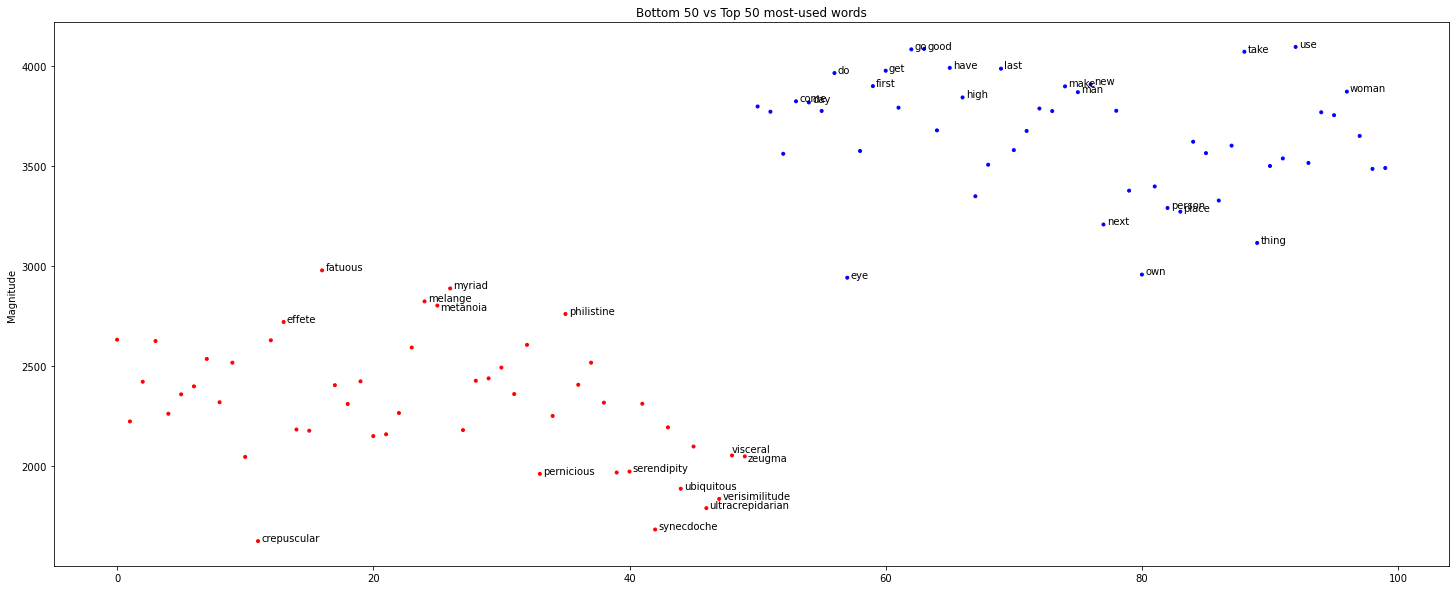

In [115]:
plt.figure(figsize=(25, 10))
plt.title('Bottom 50 vs Top 50 most-used words')
plt.ylabel('Magnitude')
plt.scatter(range(100), Y_opt, c=colors, marker='.')
for i in range(0, 100):
    if i < 48:
        if i == 25:
            plt.annotate(X[i], (i+0.25, Y_opt[i]-20))
        elif i == 39: continue
        elif Y_opt[i] > 2700:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
        elif Y_opt[i] < 2000:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
    elif i == 48:
        plt.annotate(X[i], (i, Y_opt[i]+15))
    elif i == 49:
        plt.annotate(X[i], (i+0.25, Y_opt[i]-25))
    else:
        if Y_opt[i] < 3300:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
        elif Y_opt[i] > 3800:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))


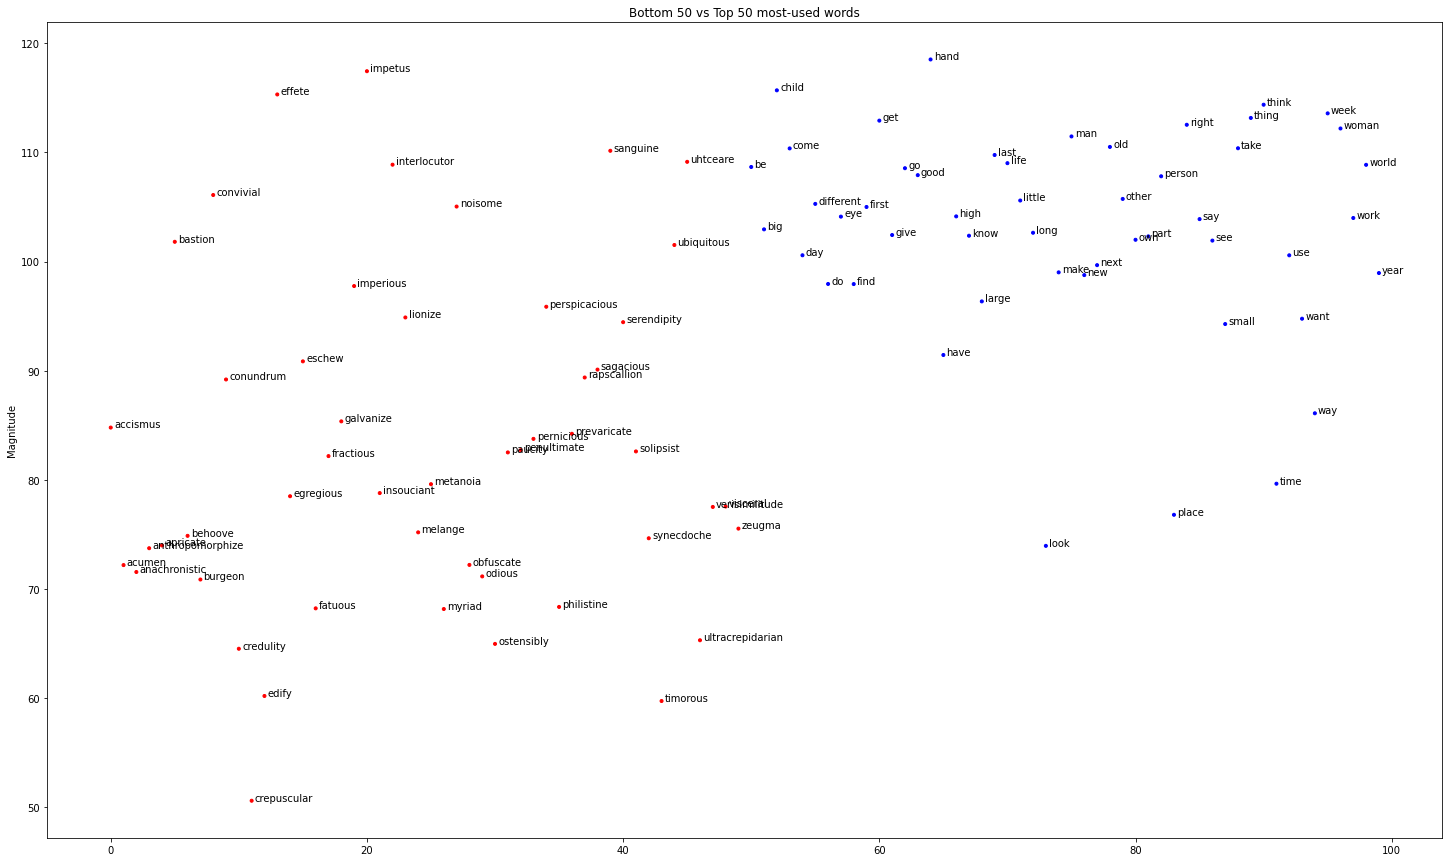

In [113]:
plt.figure(figsize=(25, 15))
plt.title('Bottom 50 vs Top 50 most-used words')
plt.ylabel('Magnitude')
plt.scatter(range(100), Y_t5, c=colors, marker='.')
for i in range(0, 100):
    plt.annotate(X[i], (i+0.25, Y_t5[i]))